## Capstone: Which Cars Should We Buy?

Over the past few weeks, you have helped Mo Cars build two different machine learning models:
- A linear regression model to predict the price that they can sell used cars for 
- A logistic regression model to predict whether or not a Craiglist post is a scam

Now, the team has provided you with a dataset of current car listings on Craigslist. Given an up-front budget of 100,000 dollars, they have asked you to submit a proposal answering the following questions:

- Which cars currently listed on Craigslist should the company buy?
- What are their expected profits if they buy those cars?
- How certain are you that you have successfully avoided scams?
- How certain are you about your profit projections?

### Instructions

1. Load the historical Mo Cars data (`used_car_dealership.csv`). Use your code from challenges one and two to re-split the data into training and test sets, prepare it, and refit your final chosen model to predict selling prices. Write a few sentences explaining your model choice. (Note: You should copy work directly from previous challenges for this step).
2. Load the historical Craigslist data (`craigslist_historical.csv`). Use your code from challenge three to re-split the data, prepare it, and re-fit your final model to predict which posts are scams. (Note: You should copy work directly from previous challenges for this step).
3. Attempt to improve upon your model from step two using regularization. Explain what you did and whether you were able to improve your model. Then, choose a final model to predict scams and write a few sentences explaining your model choice.
4. Now that you've chosen two models to predict selling prices and scams, refit these models to the entire historical Mo Cars dataset (`used_car_dealership.csv`) and historical Craigslist dataset (`craigslist_historical.csv`). This time, you will be fitting the models to all the available data, rather than just the training set, so you'll need to re-prepare these datasets using the same methods you used in steps one and two.
5. Load and inspect the current Craigslist listings, which are saved as `craigslist_available_now.csv`. Using this data, you'll be predicting the price that you can sell each car for and whether or not each post is a scam. Clean the data as needed, including inspecting and addressing missing values. Remember that the columns in this unlabeled data will need to be prepared in exactly the same way as you prepared the other two datasets.
6. Use your final models from step four to predict a) the price you could resell each current listing at and b) whether each current listing is a scam.
7. Use your models and predictions to answer the questions listed above (i.e., which cars should you spend your budget on and why?) and prepare a recommendation for the Mo Cars management team.

### Consider

- How can you use model evaluation metrics to describe your certainty about the predictions from each model?
- What are the potential limitations of your findings?
- What other approaches to this business problem could you want to try in the future?

### Submit Your Work

Your final submission should include:
- The code you used to generate the findings and/or visualizations that are included in your presentation (which can be submitted in this Jupyter notebook)
- A presentation of your findings, submitted as a PDF. You’ll also present these slides to the Mo Cars management team in the final live session.

In [1]:
# Load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
import sklearn.linear_model 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
print('The libraries are loaded')

# Load data
history = pd.read_csv("craigslist_historical.csv")
MoCars = pd.read_csv("used_car_dealership.csv")
available = pd.read_csv("craigslist_available_now.csv")

The libraries are loaded


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 833 entries, 0 to 832
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sale_price    833 non-null    int64  
 1   year          833 non-null    float64
 2   manufacturer  833 non-null    object 
 3   model         833 non-null    object 
 4   condition     833 non-null    object 
 5   fuel          832 non-null    object 
 6   odometer      823 non-null    float64
 7   transmission  833 non-null    object 
 8   paint_color   833 non-null    object 
 9   horsepower    832 non-null    float64
 10  cylinders     833 non-null    float64
 11  num_doors     833 non-null    float64
 12  highway_mpg   833 non-null    float64
 13  city_mpg      833 non-null    float64
dtypes: float64(7), int64(1), object(6)
memory usage: 91.2+ KB


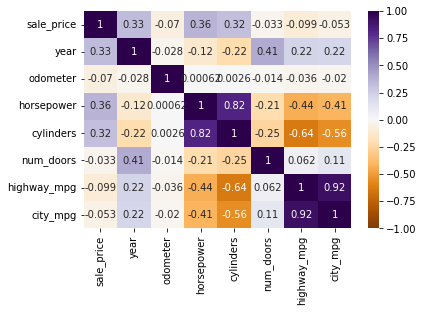

In [2]:
### Inspect the historical Mo Cars data ###
MoCars.info()
# Note: Columns with null values are fuel, odometer, and horsepower. 
#       Categorical columns are manufacturer, model, condition, fuel, transmission, and paint_color.

# Correlation Grid visualized using heatmap
corr_grid = MoCars.corr()
sns.heatmap(corr_grid, xticklabels=corr_grid.columns, yticklabels=corr_grid.columns, vmin=-1, center=0, vmax=1, cmap='PuOr', annot=True)
plt.show()
# Note: Columns with high correlation to each other are highway_mpg & city_mpg, horsepower & cylinders


In [3]:
### CLEAN historical Mo Cars data ###
# Fill missing values
MoCars.fuel.isna()
MoCars.fuel.value_counts()
MoCars[MoCars.manufacturer == 'chrysler'].fuel.value_counts()
# Note: Because almost all chrysler cars have fuel type gas, we filled missing fuel value with gas
MoCars['fuel'] = MoCars.fuel.fillna('gas')

MoCars.horsepower.isna()
MoCars.horsepower.value_counts()
# Note: Because horsepower is a numerical column, we will fill the missing value with the mean
MoCars['horsepower'] = MoCars.horsepower.fillna(MoCars['horsepower'].mean())

MoCars[MoCars.odometer.isna()]
MoCars.odometer.value_counts()
# Note: Because odometer is a numerical column, we will fill the missing value with the mean
MoCars['odometer'] = MoCars.odometer.fillna(MoCars['odometer'].mean())

# Collapsing Categories into 'other' #
manufacturer_cts = MoCars['manufacturer'].value_counts()
# Pulling out all categories other than the top 3
cats_to_collapse = manufacturer_cts.index[3:]
MoCars.loc[(MoCars['manufacturer'].isin(cats_to_collapse)), 'manufacturer'] = 'other'



### TRAIN TEST SPLIT ###
# Separate out predictors 
predictor_cols = ['manufacturer', 'year','highway_mpg', 'num_doors',
                  'fuel', 'odometer', 'horsepower', 'transmission', 'paint_color']
predictors = MoCars[predictor_cols]
outcome = MoCars['sale_price']

# Split into training and test sets 
X_train, X_test, y_train, y_test = \
train_test_split(predictors, outcome, random_state = 1, test_size=0.2)



### TRANSFORM historical Mo Cars data ### 
# STANDARDIZE NUMERICAL COLUMNS #
transformer = StandardScaler()
numerical_cols = ['year', 'highway_mpg', 'num_doors', 'odometer', 'horsepower']

# Train Data
numerical_df = X_train[numerical_cols]
X_train_numerical = pd.DataFrame(transformer.fit_transform(X_train[numerical_cols]),
                                 columns = numerical_cols,
                                 index = X_train.index)
X_train_numerical.head()
X_train[numerical_cols] = X_train_numerical

# Test Data
numerical_df = X_test[numerical_cols]
X_test_numerical = pd.DataFrame(transformer.fit_transform(X_test[numerical_cols]),
                                 columns = numerical_cols,
                                 index = X_test.index)
X_test_numerical.head()
X_test[numerical_cols] = X_test_numerical


# ORDINALLY ENCODE CATEGORICAL VARIABLES #
# Train Data
categorical_columns_ordinal = ['fuel']

# For each column, list the categories in order; we'll encode the missing data as 0s
ordered_cats = [[ 'other', 'electric', 'diesel', 'hybrid', 'gas']]

# Create an ordinal encoder
oe = OrdinalEncoder(categories = ordered_cats)

# Fit and transform the training data
df_oe_train = oe.fit_transform(X_train[categorical_columns_ordinal])

# Convert the result back to a dataframe and inspect it
col_names = categorical_columns_ordinal
df_oe_train = pd.DataFrame(df_oe_train, columns = col_names, index=X_train.index)
df_oe_train.head(5)

# Replace with the ordinal values and save as a new column
X_train['fuel_Coded'] = df_oe_train

# Test Data
# Transform the test data
df_oe_test = oe.fit_transform(X_test[categorical_columns_ordinal])

# Convert the result back to a dataframe
df_oe_test = pd.DataFrame(df_oe_test, columns = col_names, index=X_test.index)

# Replace in X_test with the ordinal values and save as a new column
X_test['fuel_Coded'] = df_oe_test
X_test.head()

# Train Data
# List out the categorical columns that we want to ordinally encode
categorical_columns_ordinal = ['transmission']

# For each column, list the categories in order; we'll encode the missing data as 0s
ordered_cats = [[ 'other', 'manual', 'automatic']]

# Create an ordinal encoder
oe = OrdinalEncoder(categories = ordered_cats)

# Fit and transform the training data
df_oe_train = oe.fit_transform(X_train[categorical_columns_ordinal])

# Convert the result back to a dataframe and inspect it
col_names = categorical_columns_ordinal
df_oe_train = pd.DataFrame(df_oe_train, columns = col_names, index=X_train.index)
df_oe_train.head(5)

# Replace with the ordinal values and save as a new column
X_train['transmission_Coded'] = df_oe_train

# Test Data
# Transform the test data
df_oe_test = oe.fit_transform(X_test[categorical_columns_ordinal])

# Convert the result back to a dataframe
df_oe_test = pd.DataFrame(df_oe_test, columns = col_names, index=X_test.index)

# Replace in X_test with the ordinal values and save as a new column
X_test['transmission_Coded'] = df_oe_test
X_test.head()


# DUMMY VARIABLES #
manufacturer_types_train = pd.get_dummies(X_train[['manufacturer']], columns =['manufacturer'])
manufacturer_types_test = pd.get_dummies(X_test[['manufacturer']], columns =['manufacturer'])

# Concatenate these new features onto the rest of the training data
X_train = pd.concat((X_train, manufacturer_types_train), axis=1)
X_test = pd.concat((X_test, manufacturer_types_test), axis=1)
X_train.head()

,manufacturer,year,highway_mpg,num_doors,fuel,odometer,horsepower,transmission,paint_color,fuel_Coded,transmission_Coded,manufacturer_chevrolet,manufacturer_ford,manufacturer_other,manufacturer_toyota
244,other,0.147328,-0.661475,0.448472,gas,-0.023556,2.134758,automatic,black,4.0,2.0,0,0,1,0
104,toyota,0.372633,2.005399,0.448472,hybrid,-0.366340,-1.723277,automatic,grey,3.0,2.0,0,0,0,1
447,chevrolet,-2.331026,0.354477,-2.266821,gas,0.099484,2.370277,automatic,blue,4.0,2.0,1,0,0,0
683,toyota,-0.753892,0.735459,0.448472,gas,0.243827,-0.826059,automatic,silver,4.0,2.0,0,0,0,1
57,other,0.597938,0.100489,0.448472,gas,-0.185464,0.418830,automatic,silver,4.0,2.0,0,0,1,0


Training Model coefficient and intercept
[ 5592.81935369  -403.14482669 -1650.82271963  -712.18316752
  -766.91622789  4736.78396609  2673.2795422   2959.32492883
  5020.09124111]
16152.324179686764
R-squared for training data:
0.3191205316294682


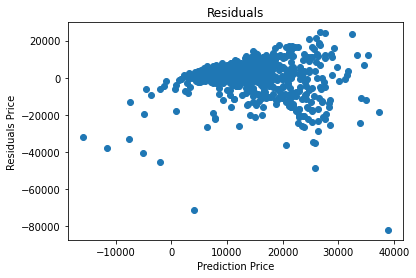

Training Model scores with 5 fold validation 
[0.32379449 0.3055579  0.28859952 0.39087926 0.07248385]
0.27626300456240915
Test Model scores with 5 fold validation 
[ 0.26800814  0.23451175 -0.48793974  0.29072568 -0.88098963]
-0.11513675797711301


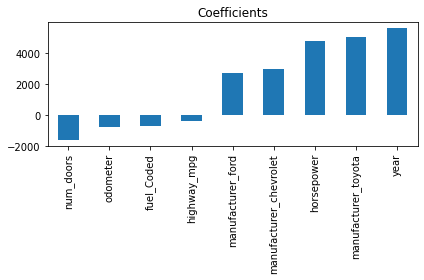

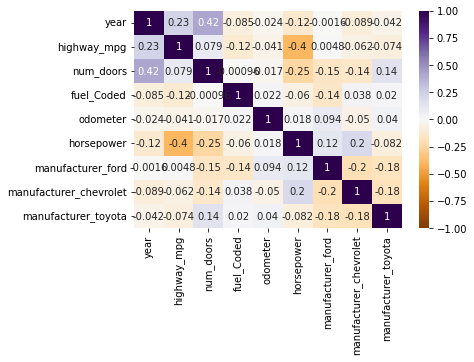

In [4]:
### CREATE AND TRAIN LINEAR MODEL ###
# Creating an empty Linear Regression model
lm_train = sklearn.linear_model.LinearRegression()
lm_test = sklearn.linear_model.LinearRegression()

# Training our model
X_train_cols = X_train[['year', 'highway_mpg', 'num_doors', 'fuel_Coded', 'odometer', 'horsepower', 
                        'manufacturer_ford', 'manufacturer_chevrolet','manufacturer_toyota']]
X_test_cols = X_test[['year', 'highway_mpg', 'num_doors', 'fuel_Coded', 'odometer', 'horsepower', 
                      'manufacturer_ford', 'manufacturer_chevrolet','manufacturer_toyota']]

lm_train.fit(X_train_cols, y_train)

# Printing the R Squared value of the model
print("Training Model coefficient and intercept")
print(lm_train.coef_)
print(lm_train.intercept_)
print("R-squared for training data:")
print(lm_train.score(X_train_cols, y_train))


# Train Data Scatter Plot
predictions_price = lm_train.predict(X_train_cols)
residuals_price = predictions_price - y_train
plt.scatter(predictions_price, residuals_price)
plt.title("Residuals")
plt.xlabel("Prediction Price")
plt.ylabel("Residuals Price")
plt.show()

# K-Fold Cross Validation
folds = KFold(n_splits = 5, shuffle = True, random_state= 1)

lm_train_scores = cross_val_score(lm_train, X_train_cols, y_train, scoring = 'r2', cv = folds)
print("Training Model scores with 5 fold validation ")
print(lm_train_scores)
print(lm_train_scores.mean())
lm_test_scores = cross_val_score(lm_test, X_test_cols, y_test, scoring = 'r2', cv = folds)
print("Test Model scores with 5 fold validation ")
print(lm_test_scores)
print(lm_test_scores.mean())

# Coefficient bar graph
predictor_names = X_train_cols.columns

coefficients = lm_train.coef_.ravel()

coef = pd.Series(coefficients, predictor_names).sort_values()
coef.plot(kind='bar', title = 'Coefficients')
plt.tight_layout()
plt.show()

# Create the correlation grid of our features
corr_grid = X_train_cols.corr()

# Use a heatmap to visualize the correlation grid
sns.heatmap(corr_grid, 
            xticklabels=corr_grid.columns, 
            yticklabels=corr_grid.columns, 
            vmin=-1, center=0, vmax=1, 
            cmap='PuOr', 
            annot=True)
plt.show()

In [5]:
#Write a few sentences explaining your linear model choice.

# I chose this model with coefficients year, highway_mpg, num_doors, fuel_Coded, odometer, 
# and manufacturer because this model that the highest R Squared value of .319 compared 
# to models with less coefficients. For example, a model with year, highway_mpg, 
# condition_Coded, transmission_Coded, and fuel_Coded had R value of .143. Also, 
# the K fold cross validation has less variance of scores with a higher mean of .276.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16542 entries, 0 to 16541
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   price            16542 non-null  int64  
 1   year             16542 non-null  float64
 2   manufacturer     16542 non-null  object 
 3   model            16542 non-null  object 
 4   condition        15710 non-null  object 
 5   fuel             16511 non-null  object 
 6   odometer         16467 non-null  float64
 7   transmission     16430 non-null  object 
 8   horsepower       16512 non-null  float64
 9   cylinders        16537 non-null  float64
 10  num_doors        16542 non-null  float64
 11  highway_mpg      16542 non-null  float64
 12  city_mpg         16542 non-null  float64
 13  paint_color      12145 non-null  object 
 14  num_typos        16542 non-null  float64
 15  num_emojis       16542 non-null  float64
 16  acct_age_yrs     16542 non-null  float64
 17  ask_downpaym

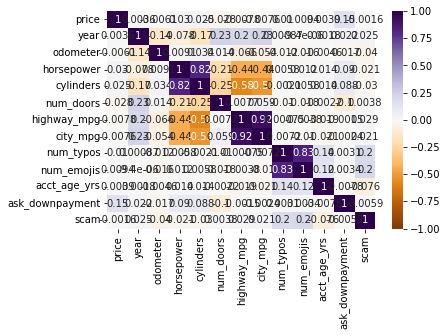

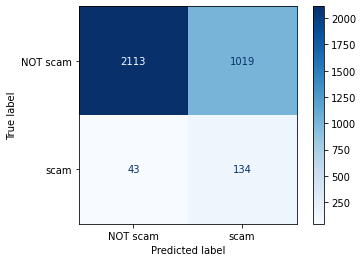

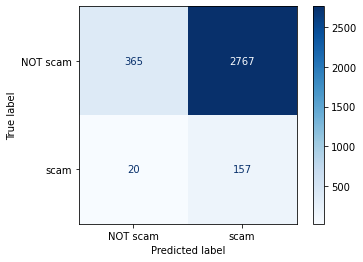

              precision    recall  f1-score   support

           0       0.98      0.67      0.80      3132
           1       0.12      0.76      0.20       177

    accuracy                           0.68      3309
   macro avg       0.55      0.72      0.50      3309
weighted avg       0.93      0.68      0.77      3309

              precision    recall  f1-score   support

           0       0.95      0.12      0.21      3132
           1       0.05      0.89      0.10       177

    accuracy                           0.16      3309
   macro avg       0.50      0.50      0.15      3309
weighted avg       0.90      0.16      0.20      3309



0.7158554668052037

In [6]:
### INSPECT historical Craigslist data ###
history.info()

### Correlation Grid
corr_grid = history.corr()
# Using a heatmap to visualize the correlation grid
sns.heatmap(corr_grid, xticklabels=corr_grid.columns, yticklabels=corr_grid.columns, vmin=-1, center=0, vmax=1, cmap='PuOr', annot=True)
plt.show()




### TRAIN TEST SPLIT ###
# Fill missing values
history.condition.isna()
history.condition.value_counts()
history['condition'] = history.condition.fillna('none')

# Separate out predictors
predictor_cols = ['price', 'year', 'condition','highway_mpg', 'city_mpg',
                  'num_typos', 'num_emojis', 'acct_age_yrs', 'ask_downpayment']
predictors = history[predictor_cols]
outcome = history['scam']

# Split into training and test sets
X_train, X_test, y_train, y_test = \
train_test_split(predictors, outcome, random_state = 3, test_size=0.2)




### ORDINALLY ENCODE CATEGORICAL VARIABLES ###
# Train Data
# List out the categorical columns that we want to ordinally encode
categorical_columns_ordinal = ['condition']

# For each column, list the categories in order; we'll encode the missing data as 0s
ordered_cats = [['none', 'salvage', 'fair', 'good', 'excellent', 'like new', 'new']]

# Create an ordinal encoder
oe = OrdinalEncoder(categories = ordered_cats)

# Fit and transform the training data
df_oe_train = oe.fit_transform(X_train[categorical_columns_ordinal])

# Convert the result back to a dataframe and inspect it
col_names = categorical_columns_ordinal
df_oe_train = pd.DataFrame(df_oe_train, columns = col_names, index=X_train.index)
df_oe_train.head(5)

# Replace with the ordinal values and save as a new column
X_train['condition_Coded'] = df_oe_train

### Test Data
# Transform the test data
df_oe_test = oe.fit_transform(X_test[categorical_columns_ordinal])

# Convert the result back to a dataframe
df_oe_test = pd.DataFrame(df_oe_test, columns = col_names, index=X_test.index)

# Replace in X_test with the ordinal values and save as a new column
X_test['condition_Coded'] = df_oe_test
X_test.head()



### BUILD AND FIT THE MODEL ###
### Model 1
# Subset the predictor set
X_train_1 = X_train[['num_typos', 'highway_mpg', 'acct_age_yrs','condition_Coded']]
X_test_1 = X_test[['num_typos', 'highway_mpg', 'acct_age_yrs','condition_Coded']]

# Train and fit the model
model_1 = LogisticRegression(class_weight = 'balanced')
model_1.fit(X_train_1, y_train)

### Model 2
# Subset the predictor set
X_train_2 = X_train[['price', 'year', 'city_mpg',
                   'num_emojis', 'ask_downpayment']]
X_test_2 = X_test[['price', 'year', 'city_mpg',
                   'num_emojis', 'ask_downpayment']]
# Train and fit the model
model_2 = LogisticRegression(class_weight = 'balanced')
model_2.fit(X_train_2, y_train)




### CHECK ASSUMPTIONS ###
### Calculate the confusion matrices
# Make predictions for the test set 
y_pred_1 = model_1.predict(X_test_1)
y_pred_2 = model_2.predict(X_test_2)

# Save the class labels
class_labels = ['NOT scam', 'scam']

# Calculate Confusion Matrix
cm_1 = metrics.confusion_matrix(y_true=y_test, y_pred=y_pred_1)
cm_2 = metrics.confusion_matrix(y_true=y_test, y_pred=y_pred_2)

### Plot the confusion matrix 
# Visualize Confusion Matrix
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=cm_1, 
                                            display_labels=class_labels)
cm_display.plot(cmap=plt.cm.Blues)
plt.show()

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=cm_2, 
                                            display_labels=class_labels)
cm_display.plot(cmap=plt.cm.Blues)
plt.show()


### True positives are craiglist posts which were correctly predicted to be a scam. 
### True negatives are posts which were correctly predicted not to be a scam. 
### False positivies are posts which were incorrectly predicted to be a scam.
### False negatives are posts which were incorrectly predicted not to be a scam

### Model 1 show:
# There are 134 true positives, 2113 true negatives, 43 false positives, and 10 false negatives
### Model 2 show:
# There are 157 true positives, 365 true negatives, 20 false positives, and 2767 false negatives


### COMPARE MODELS ###
# Performance summaries
# Model 1
print(metrics.classification_report(y_test, y_pred_1))
# Model 2
print(metrics.classification_report(y_test, y_pred_2))

# Calculate AUC 
metrics.roc_auc_score(y_test, y_pred_1)


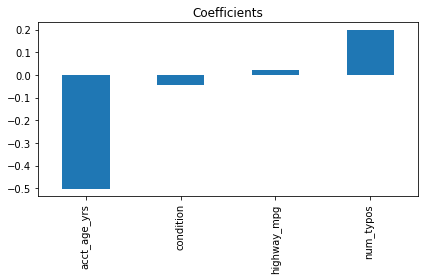

In [7]:
# Calculate AUC 
metrics.roc_auc_score(y_test, y_pred_2)

### Model 1 has overall better precision and recall with f1-scores of .80 for not scam 
### and .20 for scam vs. Model 2 with .21 for not scam and .10 for scam.
### The accuracy was also a lot higher with Model 1 at 68 and Model 2 at .16
### This means that Model 1 has a greater proportion of correctly classified data points and 
### greater proportion of correctly predicting positive values.
### Also, the AUC for Model 1 was higher(.72) than for Model 2(.50).
### This aligns with our previous data with Model 1 being closer to best AUC (1.0).
### Therefore we would pick Model 1.

# Create a graph of the coefficients
predictors = history[['num_typos', 'highway_mpg', 'acct_age_yrs','condition']]
predictor_names = predictors.columns
coefficients = model_1.coef_.ravel()
coef = pd.Series(coefficients,predictor_names).sort_values()
coef.plot(kind='bar', title = 'Coefficients')
plt.tight_layout()
plt.show()

### acct_age_yrs and num_typos seems to be the best predictors for our model.

Training set accuracy: 0.6745258066953828
Test set accuracy: 0.6790571169537625


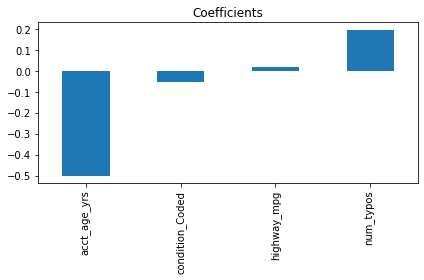

Training set accuracy: 0.6762638857401949
Test set accuracy: 0.6790571169537625


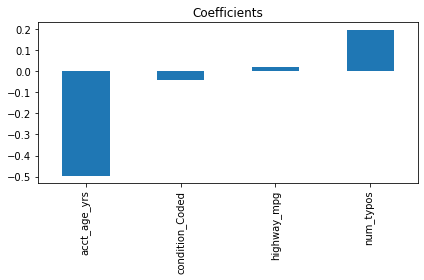

In [8]:
### LASSO REGRESSION
# Create and fit the model
log_model_lasso = LogisticRegression(penalty='l1', C=.1, solver='liblinear',
                               class_weight='balanced')
log_model_lasso.fit(X_train_1, y_train)

# Print accuracy for the training and test sets
print('Training set accuracy:', log_model_lasso.score(X_train_1, y_train))
print('Test set accuracy:', log_model_lasso.score(X_test_1, y_test))

# Create a graph of the coefficients
predictor_names = X_train_1.columns
coefficients = log_model_lasso.coef_.ravel()
coef = pd.Series(coefficients,predictor_names).sort_values()
coef.plot(kind='bar', title = 'Coefficients')
plt.tight_layout()
plt.show()

### None of the coefficients for the model became zero or much smaller. Setting the C value to 
### .1 gave us the best training and test set accuracy. The training set accuracy only slightly
### decreased to 0.674 (compared to 0.68 in the non-regularized model), showcasing our model 
### is less susceptible to issues related to collinearity. 

### RIDGE REGRESSION
log_model_ridge = LogisticRegression(solver='lbfgs', penalty='l2', C=.025, class_weight='balanced')
log_model_ridge.fit(X_train_1, y_train)

print('Training set accuracy:', log_model_ridge.score(X_train_1, y_train))
print('Test set accuracy:', log_model_ridge.score(X_test_1, y_test))

# Create a graph of the coefficients
predictor_names = X_test_1.columns
coefficients = log_model_ridge.coef_.ravel()
coef = pd.Series(coefficients,predictor_names).sort_values()
coef.plot(kind='bar', title = 'Coefficients')
plt.tight_layout()
plt.show()

### This has a similar effect to Lasso regression with an accuracy of .676. Setting the C value
### to .025 gave us the best training and test set accuracy. Ridge regression 
### is often used as a way of evaluating feature importance compared to Lasso regression which is 
### considered a feature selection method.



In [9]:
### Then, choose a final model to predict scams ###
### Model 1 has overall better precision and recall with f1-scores of .80 for not scam 
### and .20 for scam vs. Model 2 with .21 for not scam and .10 for scam.
### The accuracy was also a lot higher with Model 1 at 68 and Model 2 at .16
### This means that Model 1 has a greater proportion of correctly classified data points and 
### greater proportion of correctly predicting positive values.
### Also, the AUC for Model 1 was higher(.72) than for Model 2(.50).
### This aligns with our previous data with Model 1 being closer to best AUC (1.0).
### Therefore we would pick Model 1.Although lasso and Ridge Regressions have similar results,
### Ridge Regression has a slightly higher trainnig set accuracy of .676 compared to .674 so we
### should pick Ridge Regression. 

Model coefficient and intercept
[ 5493.66119963  -378.05449145 -1652.78424248  -648.69660648
  -814.11201529  4496.84649673  1934.31819981  2991.37330087
  4867.51394153]
15807.534892190659
R-squared for data:
0.3109584081960014


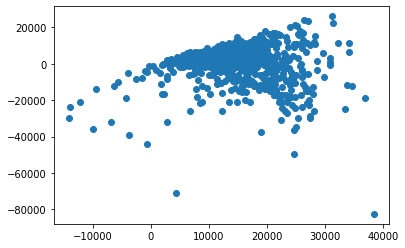

Model scores with 5 fold validation 
[0.25005986 0.13698105 0.34965643 0.38301867 0.26543369]
0.27702993987771307


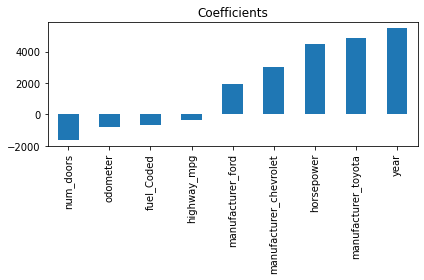

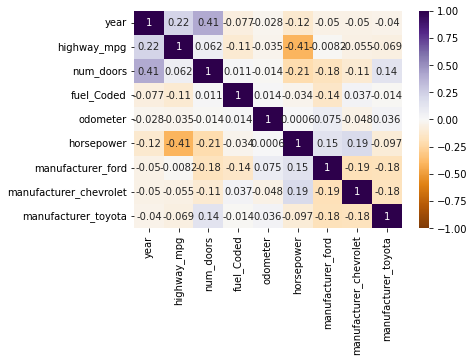

In [10]:
# Separate out predictors 
predictor_cols = ['manufacturer', 'year','highway_mpg', 'num_doors',
                  'fuel', 'odometer', 'horsepower', 'transmission', 'paint_color']
predictors = MoCars[predictor_cols]
outcome = MoCars['sale_price']


### TRANSFORM historical Mo Cars data ### 
# STANDARDIZE NUMERICAL COLUMNS #
transformer = StandardScaler()
numerical_cols = ['year', 'highway_mpg', 'num_doors', 'odometer', 'horsepower']

numerical_df = MoCars[numerical_cols]
MoCars_numerical = pd.DataFrame(transformer.fit_transform(MoCars[numerical_cols]),
                                 columns = numerical_cols,
                                 index = MoCars.index)
MoCars_numerical.head()
MoCars[numerical_cols] = MoCars_numerical


# ORDINALLY ENCODE CATEGORICAL VARIABLES #
categorical_columns_ordinal = ['fuel']
# For each column, list the categories in order; we'll encode the missing data as 0s
ordered_cats = [[ 'other', 'electric', 'diesel', 'hybrid', 'gas']]
# Create an ordinal encoder
oe = OrdinalEncoder(categories = ordered_cats)
# Fit and transform the training data
df_oe = oe.fit_transform(MoCars[categorical_columns_ordinal])
# Convert the result back to a dataframe and inspect it
col_names = categorical_columns_ordinal
df_oe = pd.DataFrame(df_oe, columns = col_names, index=MoCars.index)
df_oe.head(5)
# Replace with the ordinal values and save as a new column
MoCars['fuel_Coded'] = df_oe


categorical_columns_ordinal = ['transmission']
# For each column, list the categories in order; we'll encode the missing data as 0s
ordered_cats = [[ 'other', 'manual', 'automatic']]
# Create an ordinal encoder
oe = OrdinalEncoder(categories = ordered_cats)
# Fit and transform the training data
df_oe = oe.fit_transform(MoCars[categorical_columns_ordinal])
# Convert the result back to a dataframe and inspect it
col_names = categorical_columns_ordinal
df_oe = pd.DataFrame(df_oe, columns = col_names, index=MoCars.index)
df_oe.head(5)
# Replace with the ordinal values and save as a new column
MoCars['transmission_Coded'] = df_oe

# DUMMY VARIABLES #
manufacturer_types = pd.get_dummies(MoCars[['manufacturer']], columns =['manufacturer'])
# Concatenate these new features onto the rest of the training data
MoCars = pd.concat((MoCars, manufacturer_types), axis=1)
MoCars.head()



### CREATE AND TRAIN LINEAR MODEL ###
# Creating an empty Linear Regression model
linear_model = sklearn.linear_model.LinearRegression()

# Training our model
MoCars_cols = MoCars[['year', 'highway_mpg', 'num_doors', 'fuel_Coded', 'odometer', 'horsepower', 
                        'manufacturer_ford', 'manufacturer_chevrolet','manufacturer_toyota']]

linear_model.fit(MoCars_cols, outcome)

# Printing the R Squared value of the model
print("Model coefficient and intercept")
print(linear_model.coef_)
print(linear_model.intercept_)
print("R-squared for data:")
print(linear_model.score(MoCars_cols, outcome))

# Data Scatter Plot
predictions_price = linear_model.predict(MoCars_cols)
residuals_price = predictions_price - outcome
plt.scatter(predictions_price, residuals_price)
plt.show()


# K-Fold Cross Validation
folds = KFold(n_splits = 5, shuffle = True, random_state= 1)

linear_model_scores = cross_val_score(linear_model, MoCars_cols, outcome, scoring = 'r2', cv = folds)
print("Model scores with 5 fold validation ")
print(linear_model_scores)
print(linear_model_scores.mean())

# Coefficient bar graph
predictor_names = MoCars_cols.columns

coefficients = linear_model.coef_.ravel()

coef = pd.Series(coefficients, predictor_names).sort_values()
coef.plot(kind='bar', title = 'Coefficients')
plt.tight_layout()
plt.show()

# Create the correlation grid of our features
corr_grid = MoCars_cols.corr()

# Use a heatmap to visualize the correlation grid
sns.heatmap(corr_grid, 
            xticklabels=corr_grid.columns, 
            yticklabels=corr_grid.columns, 
            vmin=-1, center=0, vmax=1, 
            cmap='PuOr', 
            annot=True)
plt.show()


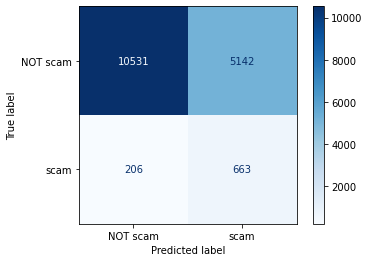

              precision    recall  f1-score   support

           0       0.98      0.67      0.80     15673
           1       0.11      0.76      0.20       869

    accuracy                           0.68     16542
   macro avg       0.55      0.72      0.50     16542
weighted avg       0.94      0.68      0.77     16542



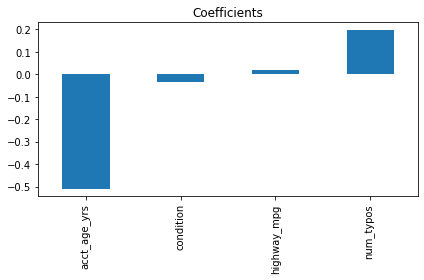

In [11]:
# Separate out predictors
predictor_cols = ['price', 'year', 'condition','highway_mpg', 'city_mpg',
                  'num_typos', 'num_emojis', 'acct_age_yrs', 'ask_downpayment']
predictors = history[predictor_cols]
outcome = history['scam']

### ORDINALLY ENCODE CATEGORICAL VARIABLES ###
# List out the categorical columns that we want to ordinally encode
categorical_columns_ordinal = ['condition']
# For each column, list the categories in order; we'll encode the missing data as 0s
ordered_cats = [['none', 'salvage', 'fair', 'good', 'excellent', 'like new', 'new']]
# Create an ordinal encoder
oe = OrdinalEncoder(categories = ordered_cats)
# Fit and transform the training data
df_oe = oe.fit_transform(history[categorical_columns_ordinal])
# Convert the result back to a dataframe and inspect it
col_names = categorical_columns_ordinal
df_oe = pd.DataFrame(df_oe, columns = col_names, index=history.index)
df_oe.head(5)
# Replace with the ordinal values and save as a new column
history['condition_Coded'] = df_oe



### BUILD AND FIT THE MODEL ###
# Subset the predictor set
history_cols = history[['num_typos', 'highway_mpg', 'acct_age_yrs','condition_Coded']]

# Train and fit the model
model_1 = LogisticRegression(class_weight = 'balanced')
model_1.fit(history_cols, outcome)


### CHECK ASSUMPTIONS ###
### Calculate the confusion matrices
# Make predictions 
y_pred_1 = model_1.predict(history_cols)

# Save the class labels
class_labels = ['NOT scam', 'scam']

# Calculate Confusion Matrix
cm_1 = metrics.confusion_matrix(y_true=outcome, y_pred=y_pred_1)

### Plot the confusion matrix 
# Visualize Confusion Matrix
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=cm_1, 
                                            display_labels=class_labels)
cm_display.plot(cmap=plt.cm.Blues)
plt.show()

# Performance summaries
# Model 1
print(metrics.classification_report(outcome, y_pred_1))

# Calculate AUC 
metrics.roc_auc_score(outcome, y_pred_1)

# Create a graph of the coefficients
predictors = available[['num_typos', 'highway_mpg', 'acct_age_yrs','condition']]
predictor_names = predictors.columns
coefficients = model_1.coef_.ravel()
coef = pd.Series(coefficients,predictor_names).sort_values()
coef.plot(kind='bar', title = 'Coefficients')
plt.tight_layout()
plt.show()

Training set accuracy: 0.6762181114738242


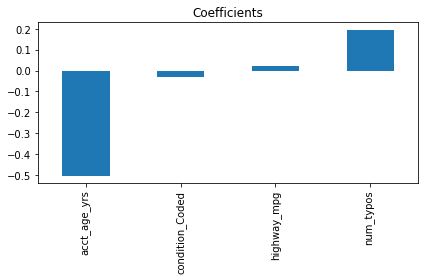

In [12]:
### RIDGE REGRESSION
log_model_ridge = LogisticRegression(solver='lbfgs', penalty='l2', C=.025, class_weight='balanced')
log_model_ridge.fit(history_cols, outcome)

print('Training set accuracy:', log_model_ridge.score(history_cols, outcome))

# Create a graph of the coefficients
predictor_names = history_cols.columns
coefficients = log_model_ridge.coef_.ravel()
coef = pd.Series(coefficients,predictor_names).sort_values()
coef.plot(kind='bar', title = 'Coefficients')
plt.tight_layout()
plt.show()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1016 entries, 0 to 1015
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   price            1016 non-null   int64  
 1   year             1016 non-null   float64
 2   manufacturer     1016 non-null   object 
 3   model            1016 non-null   object 
 4   condition        971 non-null    object 
 5   fuel             1015 non-null   object 
 6   odometer         1010 non-null   float64
 7   transmission     1013 non-null   object 
 8   horsepower       1013 non-null   float64
 9   cylinders        1016 non-null   float64
 10  num_doors        1016 non-null   float64
 11  highway_mpg      1016 non-null   float64
 12  city_mpg         1016 non-null   float64
 13  paint_color      727 non-null    object 
 14  num_typos        1016 non-null   float64
 15  num_emojis       1016 non-null   float64
 16  acct_age_yrs     1016 non-null   float64
 17  ask_downpaymen

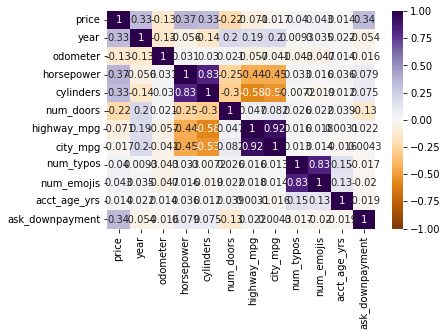

In [13]:
### Load and inspect the current Craigslist listings, which are saved as craigslist_available_now.csv. 
available.info()
# Note: Columns with null values are condition, fuel, odometer, transmission, horsepower, and paint_color.
#       Categorical columns are manufacturer, model, condition, fuel, transmission, and paint_color.

# Correlation Grid visualized using heatmap
corr_grid = available.corr()
sns.heatmap(corr_grid, xticklabels=corr_grid.columns, yticklabels=corr_grid.columns, vmin=-1, center=0, vmax=1, cmap='PuOr', annot=True)
plt.show()
# Note: Columns with high correlation to each other are highway_mpg & city_mpg, horsepower & cylinders


### CLEAN data ###
# Fill missing values
available.condition.isna()
available.condition.value_counts()
available['condition'] = available.condition.fillna('none')

available.fuel.isna()
available.fuel.value_counts()
available[available.manufacturer == 'chrysler'].fuel.value_counts()
# Note: Because almost all chrysler cars have fuel type gas, we filled missing fuel value with gas
available['fuel'] = available.fuel.fillna('gas')

available.horsepower.isna()
available.horsepower.value_counts()
# Note: Because horsepower is a numerical column, we will fill the missing value with the mean
available['horsepower'] = available.horsepower.fillna(available['horsepower'].mean())

available.transmission.value_counts()
available['transmission'] = available.transmission.fillna('automatic')

available[available.odometer.isna()]
available.odometer.value_counts()
# Note: Because odometer is a numerical column, we will fill the missing value with the mean
available['odometer'] = available.odometer.fillna(available['odometer'].mean())

available.paint_color.isna()
available.paint_color.value_counts()
available['paint_color'] = available['paint_color'].fillna('none')

# Collapsing Categories into 'other' #
manufacturer_cts = available['manufacturer'].value_counts()
# Pulling out all categories other than the top 3
cats_to_collapse = manufacturer_cts.index[3:]
available.loc[(available['manufacturer'].isin(cats_to_collapse)), 'manufacturer'] = 'other'

In [14]:
### TRANSFORM data ### 
# STANDARDIZE NUMERICAL COLUMNS #
transformer = StandardScaler()
numerical_cols = ['year', 'highway_mpg', 'num_doors', 'odometer', 'horsepower', 'num_typos', 'acct_age_yrs']

numerical_df = available[numerical_cols]
available_numerical = pd.DataFrame(transformer.fit_transform(available[numerical_cols]),
                                 columns = numerical_cols,
                                 index = available.index)
available_numerical.head()
available[numerical_cols] = available_numerical


# ORDINALLY ENCODE CATEGORICAL VARIABLES #
categorical_columns_ordinal = ['fuel']
# For each column, list the categories in order; we'll encode the missing data as 0s
ordered_cats = [[ 'other', 'electric', 'diesel', 'hybrid', 'gas']]
# Create an ordinal encoder
oe = OrdinalEncoder(categories = ordered_cats)
# Fit and transform the training data
df_oe = oe.fit_transform(available[categorical_columns_ordinal])
# Convert the result back to a dataframe and inspect it
col_names = categorical_columns_ordinal
df_oe = pd.DataFrame(df_oe, columns = col_names, index=available.index)
df_oe.head(5)
# Replace with the ordinal values and save as a new column
available['fuel_Coded'] = df_oe


categorical_columns_ordinal = ['transmission']
# For each column, list the categories in order; we'll encode the missing data as 0s
ordered_cats = [[ 'other', 'manual', 'automatic']]
# Create an ordinal encoder
oe = OrdinalEncoder(categories = ordered_cats)
# Fit and transform the training data
df_oe = oe.fit_transform(available[categorical_columns_ordinal])
# Convert the result back to a dataframe and inspect it
col_names = categorical_columns_ordinal
df_oe = pd.DataFrame(df_oe, columns = col_names, index=available.index)
df_oe.head(5)
# Replace with the ordinal values and save as a new column
available['transmission_Coded'] = df_oe

### ORDINALLY ENCODE CATEGORICAL VARIABLES ###
# List out the categorical columns that we want to ordinally encode
categorical_columns_ordinal = ['condition']
# For each column, list the categories in order; we'll encode the missing data as 0s
ordered_cats = [['none', 'salvage', 'fair', 'good', 'excellent', 'like new', 'new']]
# Create an ordinal encoder
oe = OrdinalEncoder(categories = ordered_cats)
# Fit and transform the training data
df_oe = oe.fit_transform(available[categorical_columns_ordinal])
# Convert the result back to a dataframe and inspect it
col_names = categorical_columns_ordinal
df_oe = pd.DataFrame(df_oe, columns = col_names, index=available.index)
df_oe.head(5)
# Replace with the ordinal values and save as a new column
available['condition_Coded'] = df_oe


# DUMMY VARIABLES #
manufacturer_types = pd.get_dummies(available[['manufacturer']], columns =['manufacturer'])
# Concatenate these new features onto the rest of the training data
available = pd.concat((available, manufacturer_types), axis=1)
available.head()

,price,year,manufacturer,model,condition,fuel,odometer,transmission,horsepower,cylinders,...,num_emojis,acct_age_yrs,ask_downpayment,fuel_Coded,transmission_Coded,condition_Coded,manufacturer_chevrolet,manufacturer_ford,manufacturer_other,manufacturer_toyota
0,10895,0.043447,chevrolet,suburban,excellent,gas,0.283707,automatic,1.211423,8.0,...,8.0,0.020428,0,4.0,2.0,4.0,1,0,0,0
1,16791,0.462523,other,200,like new,gas,-0.049310,automatic,-0.784656,4.0,...,9.0,1.061877,0,4.0,2.0,5.0,0,0,1,0
2,3000,-1.213779,toyota,camry,good,gas,0.272541,automatic,-0.852320,4.0,...,3.0,-1.244189,0,4.0,2.0,3.0,0,0,0,1
3,5190,0.183139,other,200,excellent,gas,-0.036114,automatic,-0.795933,4.0,...,11.0,0.020428,0,4.0,2.0,4.0,0,0,1,0
4,4995,-1.074087,other,vibe,excellent,gas,0.241837,automatic,-1.461293,4.0,...,7.0,1.285045,0,4.0,2.0,4.0,0,0,1,0


Model coefficient and intercept
[ 4895.45524596  -397.90410615 -2481.85990593 -2670.99393419
 -1165.30552793  4101.15066856  2897.62694823  3160.92854955
  3139.20073613]
24006.74220469204
R-squared for data:
0.3483488892181297


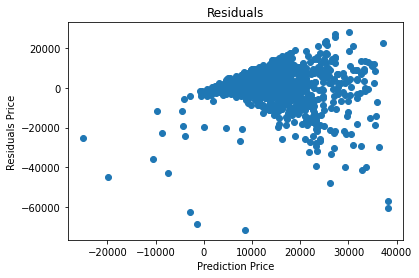

Model scores with 5 fold validation 
[ 0.0568749   0.14824715 -3.93737659  0.34927189  0.41941318]
-0.5927138957569841


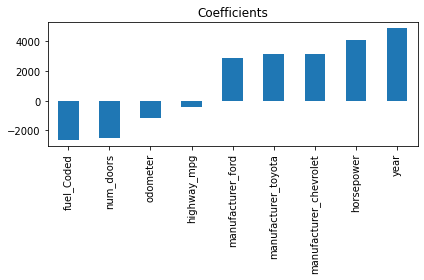

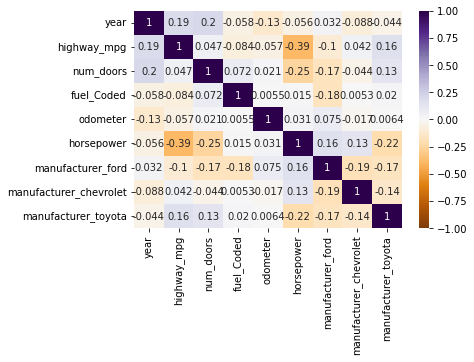

20338.44123598


In [15]:
### Use your final models to predict a) the price you could resell each current listing at
# Separate out predictors 
predictor_cols = ['year', 'highway_mpg', 'num_doors', 'fuel_Coded', 'odometer', 'horsepower', 
                        'manufacturer_ford', 'manufacturer_chevrolet','manufacturer_toyota']
predictors = available[predictor_cols]
outcome = available['price']

linear_model.fit(predictors, outcome)

# Printing the R Squared value of the model
print("Model coefficient and intercept")
print(linear_model.coef_)
print(linear_model.intercept_)
print("R-squared for data:")
print(linear_model.score(predictors, outcome))

# Data Scatter Plot
predictions_price = linear_model.predict(predictors)
residuals_price = predictions_price - outcome
plt.scatter(predictions_price, residuals_price)
plt.title("Residuals")
plt.xlabel("Prediction Price")
plt.ylabel("Residuals Price")
plt.show()

# K-Fold Cross Validation
folds = KFold(n_splits = 5, shuffle = True, random_state= 1)

linear_model_scores = cross_val_score(linear_model, predictors, outcome, scoring = 'r2', cv = folds)
print("Model scores with 5 fold validation ")
print(linear_model_scores)
print(linear_model_scores.mean())

# Coefficient bar graph
predictor_names = predictors.columns
coefficients = linear_model.coef_.ravel()
coef = pd.Series(coefficients, predictor_names).sort_values()
coef.plot(kind='bar', title = 'Coefficients')
plt.tight_layout()
plt.show()

# Create the correlation grid of our features
corr_grid = predictors.corr()

# Use a heatmap to visualize the correlation grid
sns.heatmap(corr_grid, 
            xticklabels=corr_grid.columns, 
            yticklabels=corr_grid.columns, 
            vmin=-1, center=0, vmax=1, 
            cmap='PuOr', 
            annot=True)
plt.show()


### Predicting the sale price of car
#predprice = 24006.742 + 4895.45 * year - 397.90 * highway_mpg - 2481.86 * num_doors - 2670.99 * fuel_Coded - 1165.30 * odometer + 4101.15 * horsepower + 2897.62 * manufacturer_ford + 3160.93 * manufacturer_chevrolet + 3139.20 * manufacturer_toyota
predprice = 24006.742 + 4895.45 * .042447 - 397.90 * -0.113826 - 2481.86 * 0.417422 - 2670.99 * 4 - 1165.30 * 0.283707 +  4101.15 * 1.211423 + 2897.62 * 0 + 3160.93 * 1 + 3139.20 * 0
print(predprice)